In [3]:
import os, json, io, nltk, re
from collections import Counter 
from dataclasses import dataclass
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

In [4]:
path_to_folder = "C:/Users/monte/_Olesya/Диплом/Основная папка/задание/Distances_between_articles_cat_NLP"
categ = json.load(open("C:/Users/monte/_Olesya/Диплом/Основная папка/задание/NatLangProc_Categ.json", "r", encoding="utf-8"))

In [5]:
@dataclass
class dist_to_root_art:
    idx: int
    art_name: str    
    distance: float
        
def my_comp_distance(x):
    return x.distance

In [6]:
def matrix_creator (name):
    art_dict = json.load(open(path_to_folder + "/" + name + ".json", "r", encoding="utf-8"))
    matrix = np.ones((203, 203))
    for i in art_dict:
        for j in art_dict[i]["distances"]:
            matrix[int(i)][int(j)] = 1 - art_dict[i]["distances"][j]["distance"]
    return matrix

In [7]:
matrix = matrix_creator("NLP_distances_result")

In [8]:
def fris_clustering_with_central_first(distance_matrix, k, max_iter=100, random_state=42):
    np.random.seed(random_state)
    n = distance_matrix.shape[0]
    prototypes = np.random.choice(n, k, replace=False)
    clusters = np.zeros(n, dtype=int)

    for iteration in range(max_iter):
        changed = False
        for i in range(n):
            distances_to_prototypes = [distance_matrix[i][p] for p in prototypes]
            closest_prototype = np.argmin(distances_to_prototypes)
            if clusters[i] != closest_prototype:
                clusters[i] = closest_prototype
                changed = True

        new_prototypes = []
        for cluster_id in range(k):
            cluster_points = np.where(clusters == cluster_id)[0]
            if len(cluster_points) == 0:
                new_prototypes.append(np.random.choice(n))
                continue
            min_total_distance = float('inf')
            best_point = cluster_points[0]
            for p in cluster_points:
                total_distance = np.sum(distance_matrix[p][cluster_points])
                if total_distance < min_total_distance:
                    min_total_distance = total_distance
                    best_point = p
            new_prototypes.append(best_point)

        if not changed or np.array_equal(prototypes, new_prototypes):
            break
        prototypes = new_prototypes

    # После кластеризации — переупорядочим номера
    labels = np.array(clusters)
    external_avg_distances = []

    for cluster_id in range(k):
        in_cluster = np.where(labels == cluster_id)[0]
        out_cluster = np.where(labels != cluster_id)[0]
        if len(in_cluster) == 0 or len(out_cluster) == 0:
            external_avg_distances.append(np.inf)
            continue
        total_dist = np.sum(distance_matrix[np.ix_(in_cluster, out_cluster)])
        avg_dist = total_dist / (len(in_cluster) * len(out_cluster))
        external_avg_distances.append(avg_dist)

    # Самый центральный кластер — с наименьшим внешним средним расстоянием
    most_central_cluster = np.argmin(external_avg_distances)

    # Переименуем кластеры так, чтобы центральный стал 0
    new_labels = np.zeros_like(labels)
    label_mapping = {most_central_cluster: 0}
    next_label = 1
    for old_label in range(k):
        if old_label == most_central_cluster:
            continue
        label_mapping[old_label] = next_label
        next_label += 1
    for i in range(len(labels)):
        new_labels[i] = label_mapping[labels[i]]

    return new_labels.tolist()

In [9]:
def visualize_clustering(distance_matrix, clusters, title="FRiS Clustering Visualization"):
    # Преобразуем матрицу расстояний в 2D-координаты с помощью MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(distance_matrix)

    clusters = np.array(clusters)
    unique_clusters = np.unique(clusters)

    # Палитра цветов
    colors = plt.cm.get_cmap('tab10', len(unique_clusters))

    # Визуализация
    plt.figure(figsize=(8, 6))
    for idx, cluster_id in enumerate(unique_clusters):
        cluster_points = coords[clusters == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    label=f"Cluster {cluster_id}", s=100, alpha=0.7, c=[colors(idx)])

    for i, (x, y) in enumerate(coords):
        plt.text(x, y, str(i), fontsize=12, ha='center', va='center', color='black', weight='bold')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
n_clusters = 10
labels = fris_clustering_with_central_first(matrix, n_clusters)
print("Метки кластеров:", labels)

Метки кластеров: [0, 9, 8, 1, 6, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 1, 9, 8, 8, 0, 8, 8, 8, 2, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 1, 8, 5, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 1, 8, 1, 8, 8, 8, 6, 1, 9, 8, 6, 1, 8, 9, 8, 8, 8, 8, 2, 3, 8, 8, 8, 8, 8, 1, 9, 8, 8, 8, 9, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 1, 8, 9, 8, 8, 8, 8, 9, 8, 8, 9, 8, 8, 8, 8, 0, 8, 2, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 9, 9, 2, 1, 1, 8, 1, 8, 6, 8, 8, 5, 1, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 9, 4, 8, 5, 8, 8, 1, 8, 9, 8, 1, 5, 8, 2, 8, 1, 9, 1, 9, 7, 8, 8, 9, 8, 7, 8, 8, 9, 8, 1, 6, 8, 8, 8, 2, 2, 8, 7, 8, 8, 9, 8, 8, 8, 8]


C:\Users\monte\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
C:\Users\monte\AppData\Local\Temp\ipykernel_14056\573752159.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


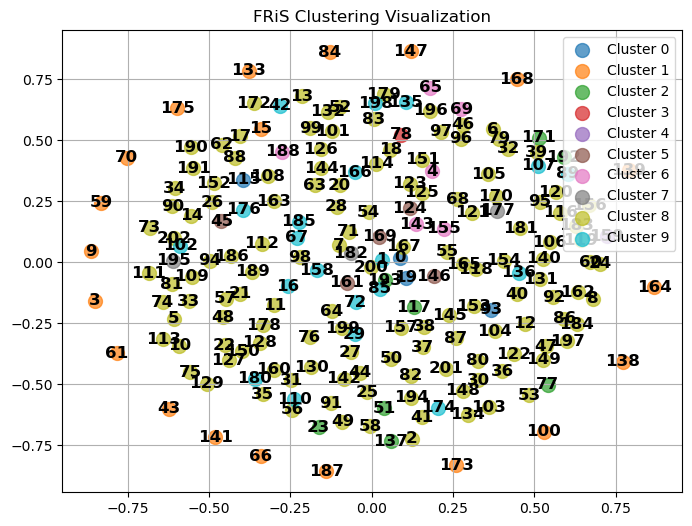

In [11]:
visualize_clustering(matrix, labels)

In [23]:
def leaders(name, labels):
    art_dict = json.load(open(path_to_folder + "/" + name + ".json", "r", encoding="utf-8"))
    result = []
    for i in art_dict:
        if labels[int(i)] == 0:
            result.append(art_dict[i]["art_name"])
    return result

In [24]:
leaders = leaders("NLP_distances_result", labels)

In [127]:
#Сравним с суммами

In [20]:
def art_sum_dist (name):
    art_dict = json.load(open(path_to_folder + "/" + name + ".json", "r", encoding="utf-8"))
    sum_list = []
    for i in art_dict:
        sum_el = 0
        for j in art_dict[i]["distances"]:
            sum_el += art_dict[i]["distances"][j]["distance"]
        c = []
        c = [i, art_dict[i]["art_name"], sum_el]
        sum_list.append(c)
    return sum_list

In [26]:
def print_sorted(name, name_json, leaders_names):
    # Создаем DataFrame и сортируем его по 'Sum_of_coef'
    df = pd.DataFrame(art_sum_dist(name_json), columns=['Index_in_cat', 'Name_of_art', 'Sum_of_coef'])
    df = df.sort_values('Sum_of_coef', ascending=False).reset_index(drop=True)
    df.index.name = 'New indexes'

    # Построение графика
    plt.figure(figsize=(12, 6))
    
    # Основные точки — серым
    plt.scatter(df.index, df['Sum_of_coef'], label='Все работы', alpha=0.6, color='gray')
    
    # Фильтруем лидеров
    leaders_df = df[df['Name_of_art'].isin(leaders_names)]
    
    # Поверх закрашиваем лидеров — другим цветом
    plt.scatter(leaders_df.index, leaders_df['Sum_of_coef'], label='Лидеры', color='orange')

    plt.title('Распределение Sum_of_coef по работам')
    plt.xlabel('Порядковый номер в отсортированном списке')
    plt.ylabel('Sum_of_coef')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Печать лидеров (если нужно вернуть — заменить на return)
    print(leaders_df)

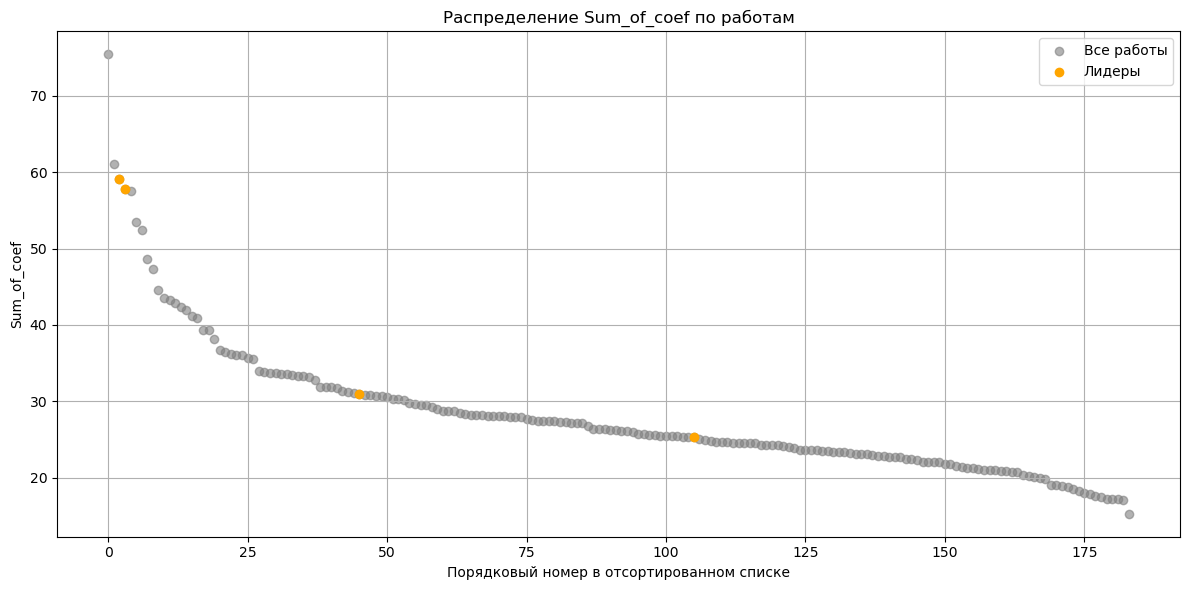

            Index_in_cat                  Name_of_art  Sum_of_coef
New indexes                                                       
2                      0  Natural language processing    59.095153
3                     19      Automatic summarization    57.877228
45                    93     Lexical Markup Framework    30.955628
105                  115        Multilingual notation    25.360991


In [27]:
print_sorted("Natural language processing", "NLP_distances_result", leaders)